# K-means, K-means++, and PCA


In [1]:
import sklearn 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn.datasets import fetch_lfw_people
#you can use python’s imaging library
from PIL import Image
from IPython.display import display

### Generate data

In [2]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.6,random_state=4)
print(X)

[[ 3.26478718e+00 -5.56939581e+00]
 [ 8.66976400e+00  4.10979732e+00]
 [ 1.06349188e+01  5.30006373e+00]
 [ 1.01653527e+01  6.74019238e-01]
 [ 9.35101820e+00  4.40689073e+00]
 [ 4.56270653e+00 -5.40246102e+00]
 [ 9.48947453e+00 -9.66084675e+00]
 [ 9.51888151e+00  3.67578903e-01]
 [ 9.74487768e+00  1.56051796e+00]
 [ 4.22717021e+00 -5.92689435e+00]
 [ 1.00217271e+01 -9.59024741e+00]
 [ 8.52789299e+00 -1.04889198e+01]
 [ 7.91273162e+00  5.80034769e-01]
 [ 1.02822681e+01  3.11326803e+00]
 [ 8.94986128e+00  1.27011577e+00]
 [ 5.57755455e+00 -5.62417765e+00]
 [ 1.04842428e+01 -9.75255780e+00]
 [ 9.21345141e+00  4.68590856e+00]
 [ 3.41113292e+00 -5.85555494e+00]
 [ 9.36377791e+00  6.56135498e-01]
 [ 9.06946470e+00 -9.78783686e+00]
 [ 9.33968610e+00  5.34358658e+00]
 [ 9.53439747e+00  5.41805919e+00]
 [ 8.92310499e+00 -9.47580123e+00]
 [ 3.80065376e+00 -5.57899382e+00]
 [ 8.96082823e+00 -1.00102859e+01]
 [ 4.18394512e+00 -5.43539406e+00]
 [ 9.21196533e+00  4.57106360e+00]
 [ 1.03727617e+01  3

### Plot the generated data

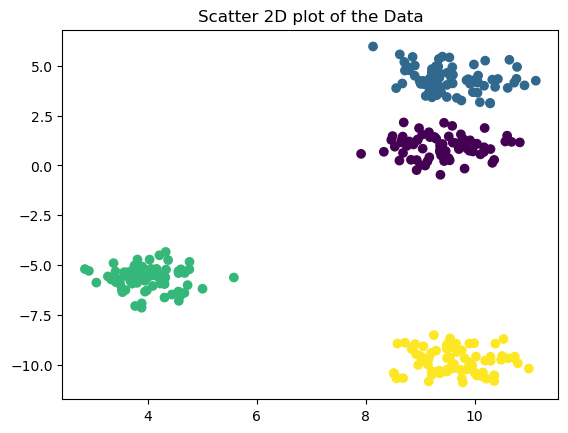

In [3]:
#2D plot
plt.scatter(X[:,0],X[:,1],c=y)
plt.title("Scatter 2D plot of the Data")
plt.show()


### Kmeans Implementation

In [4]:
#return distance between a point and each centroids
def distance(point,all_cent):
    return(np.sqrt(np.sum((point-all_cent)**2,axis=1)))

def k_means(X,max_iterations,kval):
    
    #create random centroids 
    
    centroids = X[np.random.choice(X.shape[0], kval, replace=False)]

    prev_centroids = centroids.copy()

    #create array to store centroid label for each point based on minimum distance
    min_distance_indices = np.zeros(X.shape[0])
    centroid_classified_list = []
    
    for i in range (max_iterations):

        #store the indice that each point's centroid will be based on distance
        for j in range (X.shape[0]):
            min_distance_indices[j] = np.argmin(distance(X[j,:],centroids))
           
        for k in range (kval):  
            #append the same centroid points as an array to the classified list 
            centroid_classified_list.append(X[np.where(min_distance_indices == k),:])
                
            #if no points for a centroid    
            if((centroid_classified_list[k]).size == 0):
                centroids[k] = prev_centroids[k]

            #update the centroid with the mean of its points
            else:
                centroids[k] = np.mean(centroid_classified_list[k],axis=1)

        #if centroid not changing 
        if(np.array_equal(centroids,prev_centroids)):
            return(min_distance_indices, centroids)
            break

        #reassign previous centroid    
        previous_centroids =  centroids.copy()
        
    return(min_distance_indices, centroids)        

### Syntethic data test and plot (default seed)

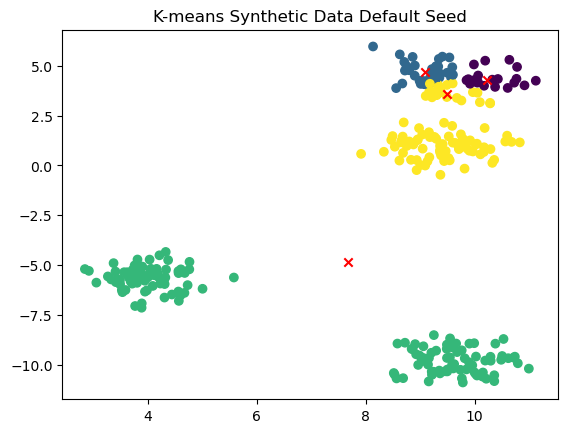

In [5]:
#initialize number of centroids and maximum iterations
k_value = 4
max_iterations = 1000

np.random.seed(None)
y,centroids = k_means(X,max_iterations,k_value)

#plot
plt.scatter(X[:,0],X[:,1],c=y)
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y,color='red',marker='x')
plt.title("K-means Synthetic Data Default Seed")
plt.show()


### Syntethic data test and plot (seed = 2)

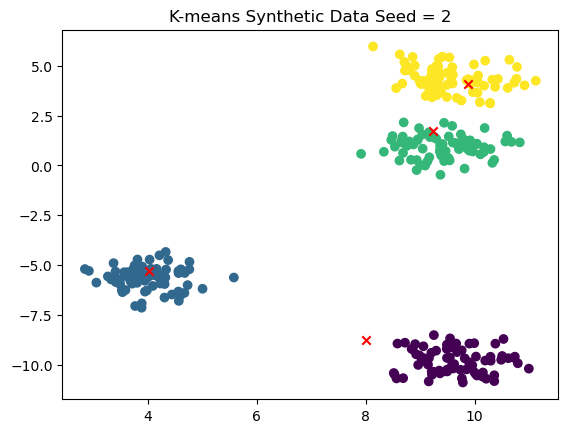

In [6]:
#initialize number of centroids and maximum iterations
k_value = 4
max_iterations = 1000

np.random.seed(2)
y,centroids = k_means(X,max_iterations,k_value)

#plot
plt.scatter(X[:,0],X[:,1],c=y)
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y,color='red',marker='x') 
plt.title("K-means Synthetic Data Seed = 2")
plt.show()


### Compare results from different seeds
As we can see from the plot and after running multiple times, the one with seed = 2 performs better in clustering than default seed. With default seed, it generates random underterministic points everytime it is run that can in turn lead to a higher lieklihood of wrong (non-optimal) clustering. However, when the seed is set, in this case to 2, deterministic set of random numbers are produced everytime it is run, and it happens that using the random numbers generated with this seed as initial centers give better result. 

### K-means ++ Implementation

In [7]:
#find the distand between a point and centroid
def single_distance(point,centroid):
    return(np.sqrt(np.sum((point-centroid)**2)))

#from already found centroids, find the once closest to a point
def closest_centroid(point,centroids):
    dist = []
    for centroid in centroids:
        dist.append(single_distance(point,centroid))

    return(centroids[np.argmin(dist)])
        
#return distance between a point and each centroids
def distance(point,all_cent):
    return(np.sqrt(np.sum((point-all_cent)**2,axis=1)))


def k_means_plpl(X,max_iterations,kval):
    
    #create centroid list and append first centroid randomly from the points
    centroids_list = []
    centroids_list.append(X[np.random.choice(X.shape[0])])

    #loop through number of centroids
    for i in range (kval-1):
        distances = np.zeros(X.shape[0])

        #loop through each point to find distance to all available centroids
        for j in range (X.shape[0]):
            close_centroid = closest_centroid(X[j,:],centroids_list)
            distances[j] = single_distance(X[j,:],close_centroid)

        #assign probability and select centroid from point depending on the probability
        prob = (distances**2)/np.sum(distances**2)
        centroids_list.append(X[np.random.choice(len(prob), p=prob)])

    #change the centroid list to array by vertically stacking
    centroids = np.vstack(centroids_list)
    prev_centroids = centroids.copy()

    #create array to store centroid for each point based on minimum distance
    min_distance_indices = np.zeros(X.shape[0])
    centroid_classified_list = []

    for i in range (max_iterations):

        for j in range (X.shape[0]):
            min_distance_indices[j] = np.argmin(distance(X[j,:],centroids))
           
        for k in range (kval):  
            
            #append the same centroid points as an array to the classified list 
            centroid_classified_list.append(X[np.where(min_distance_indices == k),:])
                
            #if no points for a centroid    
            if((centroid_classified_list[k]).size == 0):
                centroids[k] = prev_centroids[k]

            #update the centroid with the mean of its points
            else:
                centroids[k] = np.mean(centroid_classified_list[k],axis=1)

        #if centroid not changing 
        if(np.array_equal(centroids,prev_centroids)):
            return(min_distance_indices, centroids)
            break

        #reassign previous centroid    
        previous_centroids =  centroids.copy()
        
    return(min_distance_indices, centroids)
            

### K-means++ synthetic data test (default seed)

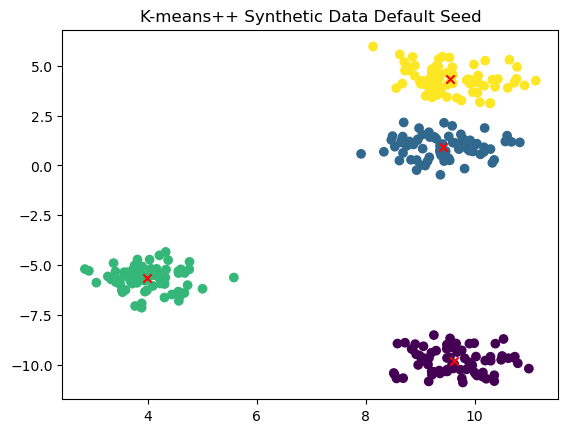

In [8]:
#initialize number of centroids and maximum iterations
k_value = 4
max_iterations = 1000

np.random.seed(None)

#use K means ++
y,centroids = k_means_plpl(X,max_iterations,k_value)

plt.scatter(X[:,0],X[:,1],c=y)
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y,color='red',marker='x')
plt.title("K-means++ Synthetic Data Default Seed")
plt.show()


### K-means++ synthetic data test (seed = 2)

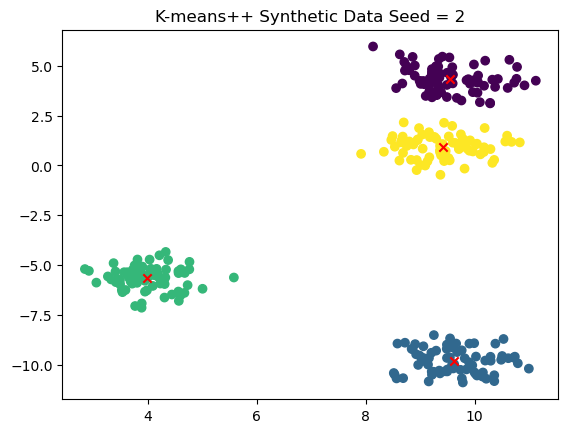

In [9]:
#initialize number of centroids and maximum iterations
k_value = 4
max_iterations = 1000

np.random.seed(2)
y,centroids = k_means_plpl(X,max_iterations,k_value)

#plot
plt.scatter(X[:,0],X[:,1],c=y)
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y,color='red',marker='x')
plt.title("K-means++ Synthetic Data Seed = 2")
plt.show()


### Compare results of default seeds and seed=2 for K-means++
As we can see K-means++ performs better than K-means which will be discussed later. In addition, when run multiple times it is easier to notice that seed = 2 performs slighlty better than defualt seed, where the random sequence is generated differently everytime you run again. Like the previous, it appears that the seed=2 random sequence performs better.

### Image Compression K-means (default seed)


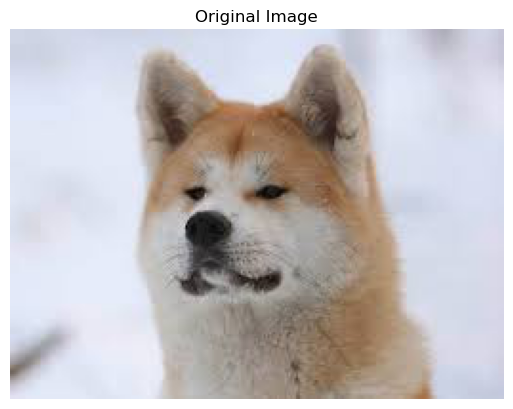

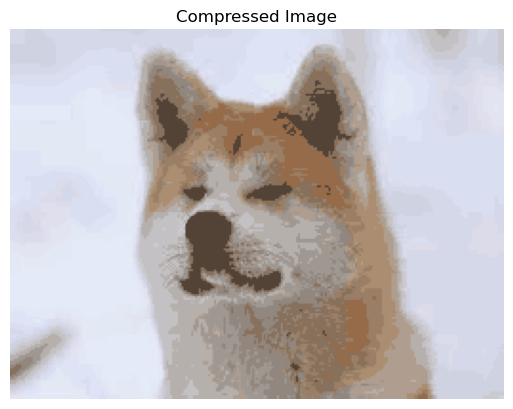

In [10]:
#default seed
np.random.seed(None)
img = plt.imread("dog.jpeg")
X_in = img.reshape(-1, 3)/255

#initialize number of centroids and maximum iterations
k_value = 20
max_iterations = 50

y, centroids =  k_means(X_in,max_iterations,k_value)
y = y.astype(int)

centroids*=255
compressed_img = ((centroids[y]).astype(np.uint8)).reshape(img.shape)

#display original and compressed image

plt.title('Original Image')
plt.imshow(img)
plt.axis('off') 
plt.show()

plt.title('Compressed Image')
plt.imshow(compressed_img)
plt.axis('off') 
plt.show()


### Image Compression K-means (seed=2)

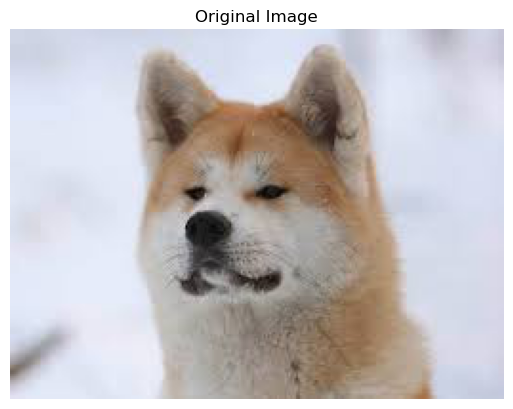

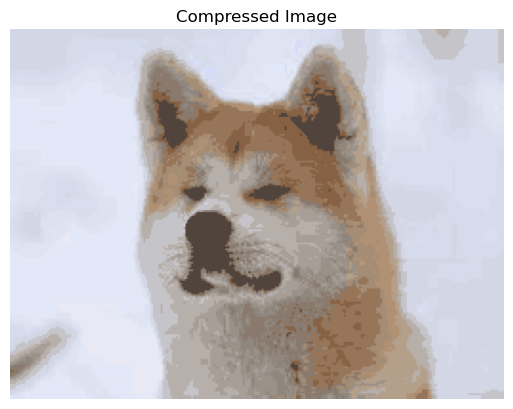

In [11]:
#seed=2
np.random.seed(2)
img = (plt.imread("dog.jpeg"))
X_in = img.reshape(-1, 3)/255


#initialize number of centroids and maximum iterations
k_value = 20
max_iterations = 50

y, centroids =  k_means(X_in,max_iterations,k_value)
y = y.astype(int)
centroids*=255
compressed_img = ((centroids[y]).astype(np.uint8)).reshape(img.shape)

#display original and compressed image

plt.title('Original Image')
plt.imshow(img)
plt.axis('off') 
plt.show()

plt.title('Compressed Image')
plt.imshow(compressed_img)
plt.axis('off') 
plt.show()


### Image Compression K-means++ (default seed)


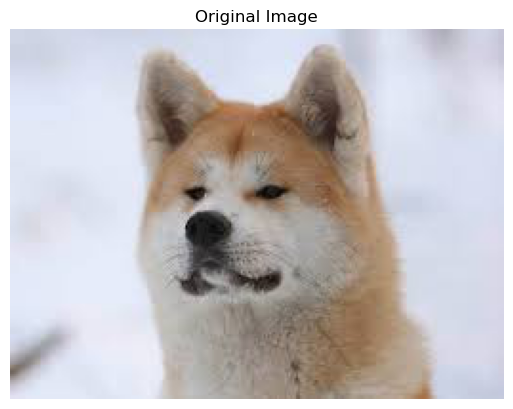

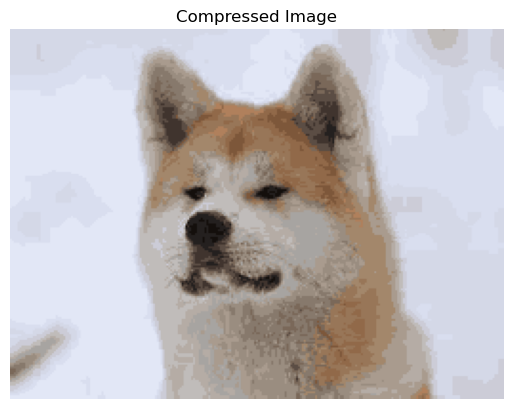

In [12]:
#seed=default
np.random.seed(None)
img = (plt.imread("dog.jpeg"))
X_in = img.reshape(-1, 3)/255


#initialize number of centroids and maximum iterations
k_value = 20
max_iterations = 50

y, centroids =  k_means_plpl(X_in,max_iterations,k_value)
y = y.astype(int)
centroids*=255
compressed_img = ((centroids[y]).astype(np.uint8)).reshape(img.shape)

#display original and compressed image
plt.title('Original Image')
plt.imshow(img)
plt.axis('off') 
plt.show()

plt.title('Compressed Image')
plt.imshow(compressed_img)
plt.axis('off') 
plt.show()


### Img Compression K-means++ (seed=2)

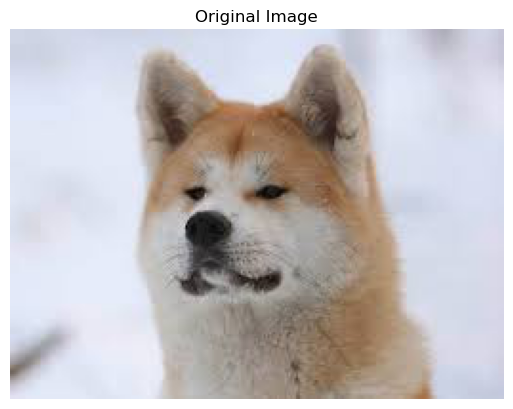

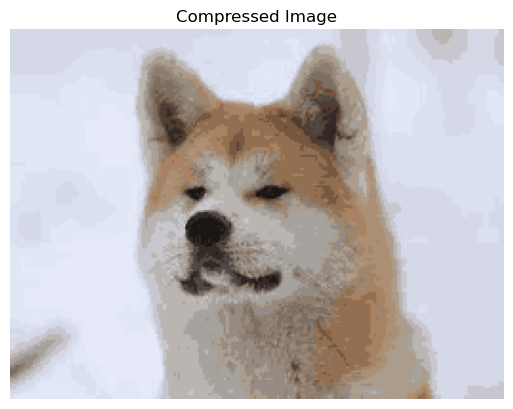

In [13]:
#seed=2
np.random.seed(2)
img = (plt.imread("dog.jpeg"))
X_in = img.reshape(-1, 3)/255


#initialize number of centroids and maximum iterations
k_value = 20
max_iterations = 50

y, centroids =  k_means_plpl(X_in,max_iterations,k_value)
centroids*=255
y = y.astype(int)
compressed_img = (((centroids[y]).astype(np.uint8)).reshape(img.shape))

#display original and compressed image
plt.title('Original Image')
plt.imshow(img)
plt.axis('off') 
plt.show()

plt.title('Compressed Image')
plt.imshow(compressed_img)
plt.axis('off') 
plt.show()


### Comparing all results
As seen from the earliest plots, for the synthetic data, k-means++ worked better than k-means which is expected. This is because k-means++ gives a better and spread out initial centers that can lead to a faster and better convergence. In addition, seed=2 gave better result than default seed, which has been explained by the fact that specifying the seed gives a specific random sequency, in which in this case the random sequence being chosen when seed=2 performs better. For the image compression, similar results were observed; k-meas++ performed significantly performed better than k-means for the same reason in the synthetic data task. However, seed = 2 didn't give significant improvement on the image compression indicating the set of random number is not that influential as in the sysnthetic daa one.



## PCA Task 1: Users to Movies


### Plot data

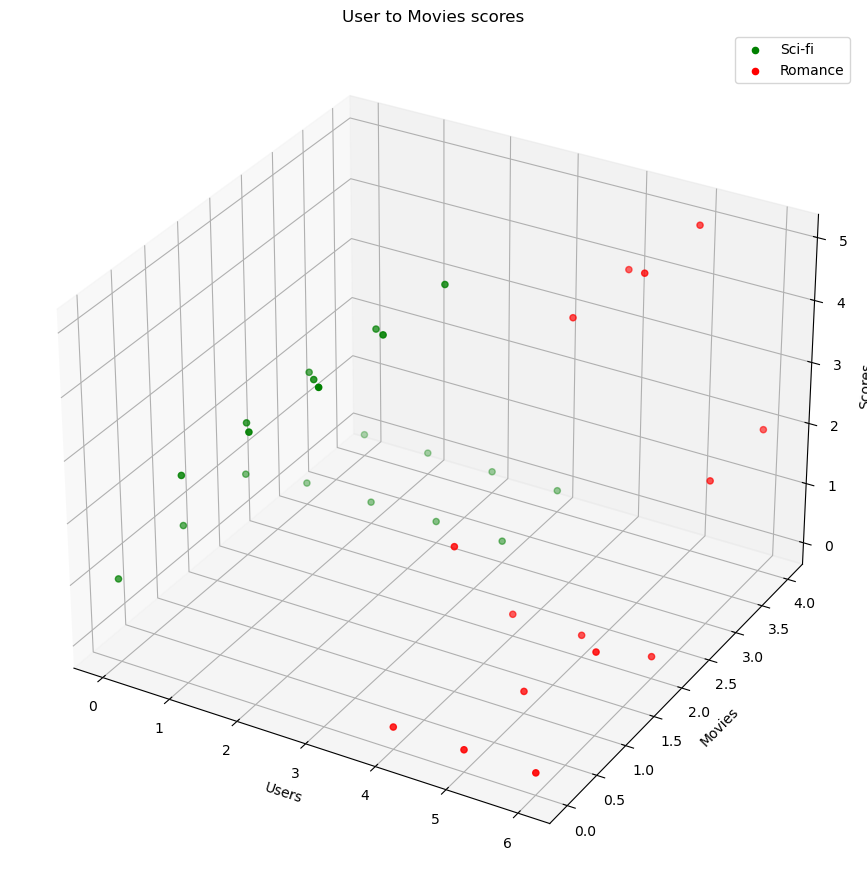

In [14]:
#load data
m=np.array([[1,1,1,0,0],
            [3,3,3,0,0],
            [4,4,4,0,0],
            [5,5,5,0,0],
            [0,2,0,4,4],
            [0,0,0,5,5],
            [0,1,0,2,2]])

#add 3D plot
fig = plt.figure(figsize=(11,11))
axis = fig.add_subplot(111, projection='3d')
axis.set_xlabel('Users')
axis.set_ylabel('Movies')
axis.set_zlabel('Scores')
axis.set_title("User to Movies scores")

#row and column size
r,c = m.shape

#green color for scif (first four rows) and red for romance
colors = ['green']*4*c + ['red']*3*c
scifi_color = np.repeat(['green'], 4*c)
romance_color = np.repeat(['red'], 3*c)
colors =  np.concatenate([scifi_color, romance_color], axis=0)

#3D scatter plots
rows = np.repeat(np.arange(r), c)
cols = np.tile(np.arange(c), r)
score = m.flatten()
axis.scatter3D(rows, cols, score, c=colors)

#plotting legend
axis.scatter3D([], [], [], c='green', label='Sci-fi')
axis.scatter3D([], [], [], c='red', label='Romance')
axis.legend()



### SVD Implementation and Plot of values

The eigenvalues are: [1.83487557e+01 2.78758798e+00 2.92227745e-01 1.04567323e-31
 7.31360204e-33]


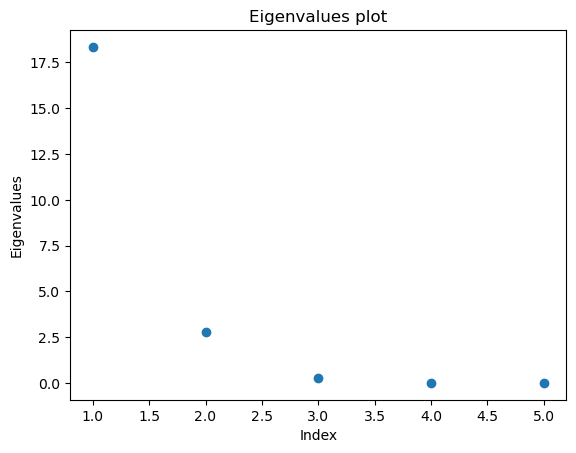

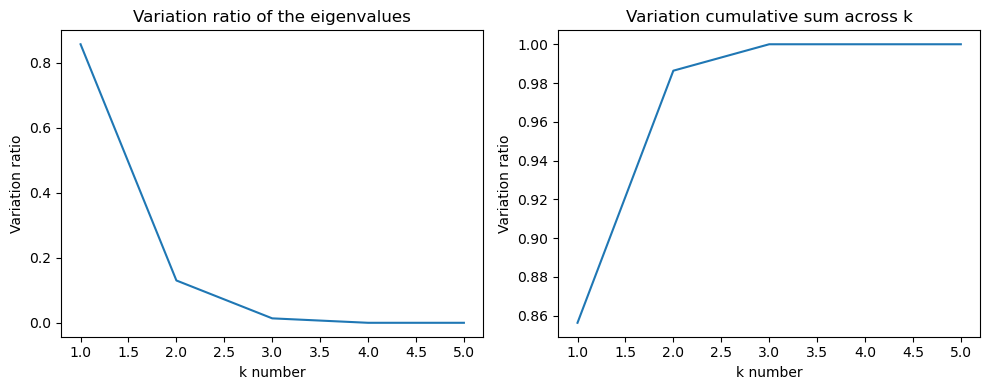

The principal components: 
 [[ 0.47149619  0.35583229]
 [ 0.37369115  0.41238396]
 [ 0.47149619  0.35583229]
 [-0.45592631  0.53698521]
 [-0.45592631  0.53698521]]
The projected m is: 
 [[ 0.14417203 -2.82787396]
 [ 2.7775391  -0.57977689]
 [ 4.09422264  0.54427165]
 [ 5.41090617  1.66832018]
 [-4.07253971  1.16872711]
 [-5.73177463  1.41792961]
 [-2.6225256  -1.3915977 ]]


In [15]:
#center data
centered_m = (m - np.mean(m,axis=0))

#SVD PCA implementation
def PCA_SVD(data):
    #get the singular values and eigenvectors
    u,s,v=np.linalg.svd(data)
    v = v.T
    
    #find the eigenvalues from the singular values
    eigen_values = s**2/(centered_m.shape[0]-1)
    
    #find the k values (with eigen values size)
    k_s = np.arange(1,eigen_values.size+1)
    
    #find the variation ratio and the cumulative sum of variation
    variation_ratio = eigen_values/(np.sum(eigen_values))
    variation_ratio_cumsum = np.cumsum(variation_ratio)
    
    #choose k resulting in total variaiton > 0.9
    k = k_s[np.argmax(variation_ratio_cumsum>0.95)]
    
    #choose the principal components from eigenvectors depending on k
    principal_comps = v[:, :k]
    return(eigen_values,principal_comps,k,k_s,variation_ratio,variation_ratio_cumsum)

eigen_values, principal_comps, k, k_s, variation_ratio, variation_ratio_cumsum = PCA_SVD(centered_m)


#plot and print the eigen values
print(f"The eigenvalues are: {eigen_values}")
plt.scatter(k_s,eigen_values)
plt.title("Eigenvalues plot")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")
plt.show()

#plot the variation ratio for the eigen values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_s,variation_ratio)
plt.title("Variation ratio of the eigenvalues")
plt.xlabel("k number")
plt.ylabel("Variation ratio")

#plot the variation cumulative sum ratio
plt.subplot(1, 2, 2)
variation_cumsum = np.cumsum(variation_ratio)
plt.plot(k_s,variation_ratio_cumsum)
plt.title("Variation cumulative sum across k")
plt.xlabel("k number")
plt.ylabel("Variation ratio")
plt.tight_layout()
plt.show()

#Print the prinicpal components
print(f"The principal components: \n {principal_comps}")

#print the compressed data
projected_m = np.dot(centered_m, principal_comps)
print(f"The projected m is: \n {projected_m}")


### PCA using covariance matrix

In [16]:
#center data
centered_m = (m - np.mean(m,axis=0))

def COV_PCA(data):
    
    #find covariance of centered data
    cov = (np.matmul(data.T,data)/(data.shape[0]-1))

    #find eigen values and eigenvectors
    s,v=np.linalg.eig(cov)

    #sort both in decsending order of eigen values
    indices = np.argsort(s)[::-1]
    s = s[indices]
    v = v[:,indices]

    #picking k value
    s_sum = np.sum(s)
    s_variation = s/(s_sum)
    s_cumsum = np.cumsum(s_variation)
    k_s = np.arange(1,s.size+1)
    k = k_s[np.argmax(s_cumsum>0.95)]

    principal_comps = (v[:, :k])
    
    return(s,v,principal_comps,k)

s,v,principal_comps,k = COV_PCA(centered_m)

#print eigen values and eigen vectors
print(f"The eigenvalues are: {s} \n")
print(f"The eignevectors are (an eigenvector is a column vector here): \n {v} \n")

m_compressed = np.dot(centered_m, principal_comps)
print(f"The principal components: \n{principal_comps}")


The eigenvalues are: [ 1.83487557e+01  2.78758798e+00  2.92227745e-01 -3.47280129e-19
 -2.68221030e-16] 

The eignevectors are (an eigenvector is a column vector here): 
 [[-4.71496193e-01 -3.55832289e-01  3.88683319e-01 -2.36355315e-02
  -7.06577489e-01]
 [-3.73691150e-01 -4.12383958e-01 -8.30839573e-01  1.01923848e-16
   2.87861399e-15]
 [-4.71496193e-01 -3.55832289e-01  3.88683319e-01  2.36355315e-02
   7.06577489e-01]
 [ 4.55926313e-01 -5.36985212e-01  6.14660890e-02 -7.06711654e-01
  -2.73541854e-02]
 [ 4.55926313e-01 -5.36985212e-01  6.14660890e-02  7.06711654e-01
   2.73541854e-02]] 

The principal components: 
[[-0.47149619 -0.35583229]
 [-0.37369115 -0.41238396]
 [-0.47149619 -0.35583229]
 [ 0.45592631 -0.53698521]
 [ 0.45592631 -0.53698521]]


### Explanations
For doing PCA with SVD using np.linalg.svd(data), the eigenvectors and the singular values which can be used to find the eigenvalues are extracted. The eigenvalues indicate the variation so the cumulative sum of the ratio of eigen values to sum of all eigenvalues is used to indicate variation. The number of eigenvalues that provide greater than 90 percent of the varation will be used for their repsective eigenvectors. In this case the first two eigenvectors were enough and are used as the principal components. The data m is then compressed by dot product of m with the principal components. The other implementation of PCA is by directly finding the eigenvalues and eigenvectors using the covaraiance matrix. Here, the eigenvalues needs to be reordered in decreasing order before choosing the principal components. The eigenvectors, eigenvalues, and the chosen principal components were similar with a shift in sign in both implementations as expected.

## PCA Task 2: Human Face Task

### Load dataset, 4th face, and mean image display

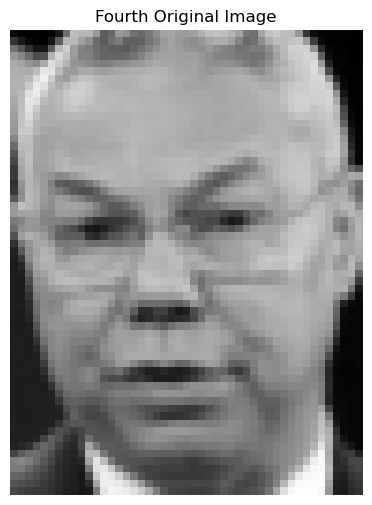

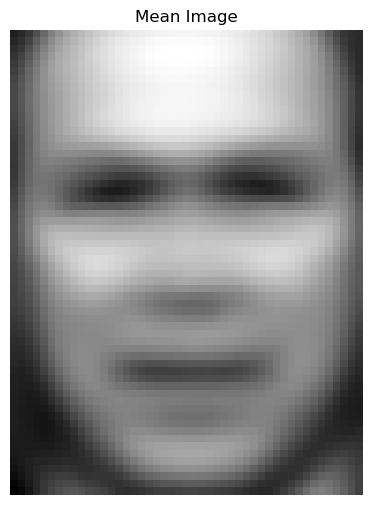

In [17]:
#load dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70)

#load third image
img = lfw_people.images[3]

#display original image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Fourth Original Image')
plt.axis('off')
plt.imshow(img,cmap='gray')

#calculate the mean of the images and display
face_data = lfw_people.data
image_mean = np.mean(face_data, axis=0)
image_mean_disp = image_mean.reshape(62,47)

#display mean image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Mean Image')
plt.axis('off')
plt.imshow(image_mean_disp,cmap='gray')


### Dimensionality Reduction (4-7)

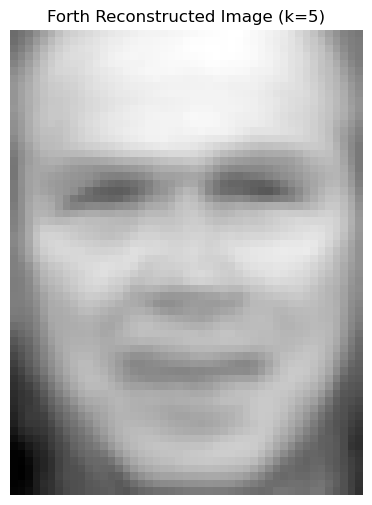

In [18]:
def COVPVC_prek(data,k):
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    
    #find covariance, eigenvalues, and eigenvectors
    cov = (np.matmul(centered_data.T,centered_data)/(centered_data.shape[0]-1))
    D,V=np.linalg.eig(cov)
    
    #sort both in decsending order of eigen values
    indices = np.argsort(D)[::-1]
    D = D[indices]
    V = V[:,indices]
    principal_comps = V[:,:k]
    
    return(principal_comps, mean)
    

#compute and print the top five principal components 
principal_comps, image_mean = COVPVC_prek(face_data,5)

#project the fourth image onto the five principal components
img_project = np.dot(face_data[3], principal_comps)
reconstruct_flat = np.dot(img_project,principal_comps.T) + image_mean
img_reconstruct = reconstruct_flat.reshape(62, 47)

#display the reconstructed fourth image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Forth Reconstructed Image (k=5)')
plt.axis('off')
plt.imshow(img_reconstruct,cmap='gray')

### 50 Principal Components

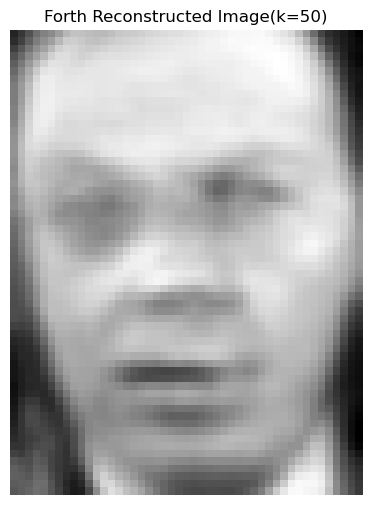

In [19]:
#compute and print the top five principal components 
principal_comps, image_mean = COVPVC_prek(face_data,50)

#project the fourth image onto the five principal components
img_project = np.dot(face_data[3], principal_comps)
reconstruct_flat = np.dot(img_project,principal_comps.T) + image_mean
img_reconstruct = reconstruct_flat.reshape(62, 47)

#display the reconstructed fourth image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Forth Reconstructed Image(k=50)')
plt.axis('off')
plt.imshow(img_reconstruct,cmap='gray')